In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
sns.set(style='darkgrid')
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import pickle

In [ ]:
games = pd.read_csv('games.csv')
players = pd.read_csv('players.csv')
plays = pd.read_csv('plays.csv')
pff = pd.read_csv('PFFScoutingData.csv')
tracking_2018 = pd.read_csv('tracking2018.csv')
tracking_2019 = pd.read_csv('tracking2019.csv')
tracking_2020 = pd.read_csv('tracking2020.csv')

In [ ]:

tracking = pd.concat([tracking_2018, tracking_2019, tracking_2020], axis=0)
tracking.reset_index(drop=True, inplace=True)

# Flip so all plays go begin with kick to the right
tracking.loc[tracking['playDirection'] == "left", 'x'] = 120-tracking.loc[tracking['playDirection'] == "left", 'x']
tracking.loc[tracking['playDirection'] == "left", 'y'] = 160/3-tracking.loc[tracking['playDirection'] == "left", 'y']

In [ ]:
tracking.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
0,2018-12-30T21:25:32.200,41.32,29.45,4.36,1.33,0.43,130.42,128.44,None,39470.0,Justin Tucker,9.0,K,home,1,2018123000,36,right
1,2018-12-30T21:25:32.300,41.68,29.17,4.59,1.24,0.45,128.59,127.81,None,39470.0,Justin Tucker,9.0,K,home,2,2018123000,36,right
2,2018-12-30T21:25:32.400,42.05,28.88,4.74,0.99,0.47,124.47,128.15,None,39470.0,Justin Tucker,9.0,K,home,3,2018123000,36,right
3,2018-12-30T21:25:32.500,42.43,28.59,4.87,0.71,0.48,126.02,127.35,None,39470.0,Justin Tucker,9.0,K,home,4,2018123000,36,right
4,2018-12-30T21:25:32.600,42.84,28.31,4.96,0.79,0.50,131.71,124.75,None,39470.0,Justin Tucker,9.0,K,home,5,2018123000,36,right


In [ ]:
punt_p = plays[plays['specialTeamsPlayType'] == 'Punt'].copy()
punt_p['yardsFromEndzone'] = np.where(punt_p['possessionTeam'] == punt_p['yardlineSide'], 100 - punt_p['yardlineNumber'], punt_p['yardlineNumber'])
conditions = [punt_p['yardsFromEndzone'].le(50), punt_p['yardsFromEndzone'].gt(50) & punt_p['yardsFromEndzone'].le(65), punt_p['yardsFromEndzone'].gt(65) & punt_p['yardsFromEndzone'].le(93), punt_p['yardsFromEndzone'].gt(93)]
choices = ['0-50', '50-65', '65-93', '93+']
punt_p['yardsFromEndzoneBucket'] = np.select(conditions, choices)

In [ ]:
punt_p.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,yardsFromEndzone,yardsFromEndzoneBucket
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,-15.0,0,0,NaN,56.0,5.0,36,18,92,65-93
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,NaN,0,3,NaN,65.0,NaN,45,45,65,50-65
5,2018090600,973,"(14:18) M.Bosher punts 49 yards to PHI 40, Cen...",2,4,19,ATL,Punt,Fair Catch,37267.0,...,NaN,0,3,NaN,49.0,NaN,49,21,89,65-93
10,2018090600,1850,"(1:30) C.Johnston punts 58 yards to ATL 11, Ce...",2,4,8,PHI,Punt,Downed,45603.0,...,NaN,3,6,NaN,58.0,NaN,58,79,69,65-93
11,2018090600,1989,"(:44) M.Bosher punts 57 yards to PHI 17, Cente...",2,4,8,ATL,Punt,Return,37267.0,...,12.0,3,6,NaN,57.0,8.0,61,36,74,65-93


In [ ]:

pff_punt = pff[pff['kickType'].isin(['N', 'R', 'A'])]

In [ ]:
pff_punt.head()

,gameId,playId,snapDetail,snapTime,operationTime,hangTime,kickType,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,returnDirectionActual,missedTackler,assistTackler,tackler,kickoffReturnFormation,gunners,puntRushers,specialTeamsSafeties,vises,kickContactType
1,2018090600,366,OK,0.84,2.12,4.46,N,C,C,C,R,PHI 57,NaN,PHI 54,NaN,PHI 18; PHI 29,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC
4,2018090600,872,OK,0.84,2.00,4.35,N,C,L,NaN,NaN,NaN,NaN,NaN,NaN,PHI 18; PHI 29,ATL 85,ATL 37,ATL 83; ATL 34; ATL 21,BF
5,2018090600,973,OK,0.86,2.19,4.98,N,L,L,NaN,NaN,NaN,NaN,NaN,NaN,ATL 83; ATL 28,PHI 28; PHI 37; PHI 54; PHI 57,NaN,PHI 29; PHI 32,CC
10,2018090600,1850,OK,0.81,2.00,4.53,N,R,R,NaN,NaN,NaN,NaN,NaN,NaN,PHI 18; PHI 29,ATL 28; ATL 85,NaN,ATL 83; ATL 23,BB
11,2018090600,1989,OK,0.76,2.12,4.62,N,C,C,C,C,ATL 83,NaN,ATL 34,NaN,ATL 83; ATL 28,NaN,NaN,PHI 29; PHI 37; PHI 32,CC


In [ ]:
punt_t = tracking.merge(pff_punt[['gameId', 'playId']],on=['gameId', 'playId'], how='inner').reset_index(drop=True)
play_cols = ['gameId', 'playId', 'kickerId', 'returnerId', 'possessionTeam', 'absoluteYardlineNumber']
pff_cols = ['gameId', 'playId', 'gunners', 'vises']
games_cols = ['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']
punt_t = punt_t.merge(plays[play_cols], on=['gameId', 'playId']).merge(pff[pff_cols], on=['gameId', 'playId']).merge(games[games_cols], on='gameId')
punt_t['kickerId'].fillna(0, inplace=True)
punt_t['kickerId'] = punt_t['kickerId'].astype(int)
punt_t['returnerId'] = punt_t['returnerId'].str.split(';').str[0]
punt_t.dropna(subset = ['returnerId'], inplace=True)
punt_t['returnerId'] = punt_t['returnerId'].astype(int)
punt_t['absoluteYardlineNumber'] = np.where(punt_t['playDirection']=='left', (punt_t['absoluteYardlineNumber'] - 120) * -1, punt_t['absoluteYardlineNumber'])
punt_t['x_adj'] = punt_t['x'] - punt_t['absoluteYardlineNumber']
punt_t['jerseyNumber'].fillna(0, inplace=True)
punt_t['teamName'] = np.where(punt_t['team']=='football', 'football', np.where(punt_t['team']=='home', punt_t['homeTeamAbbr'],punt_t['visitorTeamAbbr']))
punt_t['teamNumber'] = punt_t['teamName'] + ' ' + punt_t['jerseyNumber'].astype(int).astype(str)
punt_t['kickingTeam'] = punt_t['teamName']==punt_t['possessionTeam']
punt_t['gunner_y_n'] = punt_t.apply(lambda row: row['teamNumber'] in str(row['gunners']), axis=1)
punt_t['vise_y_n'] = punt_t.apply(lambda row: row['teamNumber'] in str(row['vises']), axis=1)
punt_t['rolePlayer'] = np.where(punt_t['nflId']==punt_t['kickerId'], 'punter', np.where(punt_t['nflId']==punt_t['returnerId'], 'returner',np.where(punt_t['gunner_y_n'], 'gunner', np.where(punt_t['vise_y_n'], 'vise', np.where(punt_t['team']=='football', 'football', 'other')))))
punt_snaps = punt_t[punt_t['event']=='ball_snap'][['gameId', 'playId', 'frameId', 'event']].drop_duplicates()
punt_snaps.rename(columns={'frameId' : 'snap'}, inplace=True)
punt_t = punt_t.merge(punt_snaps[['gameId', 'playId', 'snap']], on=['gameId', 'playId'])
punt_t['frameVsSnap'] = punt_t['frameId'] - punt_t['snap']
exclude = ['punter', 'returner', 'football']
group_cols = ['gameId', 'playId', 'frameVsSnap', 'teamName']
penetration_kicking = punt_t[(~punt_t['rolePlayer'].isin(exclude)) &(punt_t['kickingTeam'])].groupby(group_cols)['x_adj'].mean().reset_index()
penetration_receiving = punt_t[(~punt_t['rolePlayer'].isin(exclude)) & (~punt_t['kickingTeam'])].groupby(group_cols)['x_adj'].mean().reset_index()
team_penetration_by_frame = penetration_kicking.merge(penetration_receiving, on=['gameId', 'playId', 'frameVsSnap'])
team_penetration_by_frame.columns = ['gameId', 'playId', 'frameVsSnap', 'kickTeam', 'kickTeamPosition', 'recTeam', 'recTeamPosition']
team_penetration_by_frame['kickTeamPenetration'] = team_penetration_by_frame['kickTeamPosition'] - team_penetration_by_frame['recTeamPosition']
include = ['gunner', 'vise']
penetration_gunner = punt_t[(punt_t['rolePlayer'].isin(include)) & (punt_t['kickingTeam'])].groupby(group_cols)['x_adj'].mean().reset_index()
penetration_vise = punt_t[(punt_t['rolePlayer'].isin(include)) &(~punt_t['kickingTeam'])].groupby(group_cols)['x_adj'].mean().reset_index()
gunner_penetration_by_frame = penetration_gunner.merge(penetration_vise, on=['gameId', 'playId', 'frameVsSnap'])
gunner_penetration_by_frame.columns = ['gameId', 'playId', 'frameVsSnap', 'kickTeam', 'gunnerPosition', 'recTeam', 'visePosition']
gunner_penetration_by_frame['gunnerPenetration'] = gunner_penetration_by_frame['gunnerPosition'] - gunner_penetration_by_frame['visePosition']
kick_team_spread = punt_t[(punt_t['kickingTeam'])].groupby(group_cols)['y'].agg({np.min,np.max}).reset_index()
kick_team_spread['max_spread'] = kick_team_spread['amax'] - kick_team_spread['amin']
kick_team_gaps = punt_t[punt_t['kickingTeam']].sort_values(['gameId', 'playId', 'frameVsSnap', 'y']).copy()
kick_team_gaps['y_gap'] = kick_team_gaps['y'].diff()
mask = ((kick_team_gaps['gameId']==kick_team_gaps['gameId'].shift(1)) & (kick_team_gaps['playId']==kick_team_gaps['playId'].shift(1)) & (kick_team_gaps['frameVsSnap']==kick_team_gaps['frameVsSnap'].shift(1)))
kick_team_gaps['y_gap'] = np.where(mask!=True, np.nan, kick_team_gaps['y_gap'])
kick_team_gaps = kick_team_gaps.groupby(['gameId', 'playId', 'frameVsSnap'])['y_gap'].std().reset_index()
kick_team_gaps.columns = ['gameId', 'playId', 'frameVsSnap', 'gapStdDev']
kick_team_spread = kick_team_spread.merge(kick_team_gaps, on=['gameId', 'playId', 'frameVsSnap'])
returner_position = punt_t[punt_t['rolePlayer']=='returner'][['gameId', 'playId', 'frameVsSnap', 'x', 'y']]
returner_position.columns = ['gameId', 'playId', 'frameVsSnap', 'x_returner', 'y_returner']
punt_t = punt_t.merge(returner_position, on=['gameId', 'playId', 'frameVsSnap'])
punt_t['dist_to_returner'] = np.sqrt((punt_t['x_returner'] - punt_t['x'])**2 + (punt_t['y_returner'] - punt_t['y'])**2)
dist_to_returner = punt_t[(~punt_t['rolePlayer'].isin(exclude)) &(punt_t['kickingTeam'])].groupby(['gameId', 'playId', 'frameVsSnap'])['dist_to_returner'].agg({np.min,np.mean}).reset_index()
dist_to_returner.columns = ['gameId', 'playId', 'frameVsSnap', 'minDist', 'meanDist']

In [ ]:
def merge_frame(df1, df2, on_cols, merge_cols, frame=[], rename_cols=[]):
    for f in frame:
        df1 = df1.merge(df2[df2['frameVsSnap']==f][merge_cols], on=on_cols)
        if rename_cols:
            for col in rename_cols:
                df1.rename(columns={col : col + '_frame' + str(f)}, inplace=True)
    return df1

In [ ]:
pff_filtered = pff_punt[['gameId', 'playId', 'snapDetail', 'operationTime', 'hangTime', 'kickDirectionActual']]
punt_plays_filtered = punt_p[['gameId', 'playId', 'specialTeamsResult', 'penaltyCodes', 'kickLength', 'kickReturnYardage', 'playResult', 'yardsFromEndzoneBucket']]
punt_data_co = pff_filtered.merge(punt_plays_filtered, on=['gameId', 'playId'], how='inner')
on_cols = ['gameId', 'playId']
merge_cols = on_cols + ['kickTeam', 'recTeam', 'kickTeamPosition', 'recTeamPosition']
rename_cols = ['kickTeamPosition', 'recTeamPosition']
punt_data_co = merge_frame(punt_data_co, team_penetration_by_frame, on_cols=on_cols, merge_cols=merge_cols, frame=[30], rename_cols=rename_cols)
merge_cols = on_cols + rename_cols
punt_data_co = merge_frame(punt_data_co, team_penetration_by_frame, on_cols=on_cols, merge_cols=merge_cols, frame=[40, 50], rename_cols=rename_cols)
rename_cols = ['gunnerPenetration']
merge_cols = on_cols + rename_cols
punt_data_co = merge_frame(punt_data_co, gunner_penetration_by_frame, on_cols=on_cols, merge_cols=merge_cols, frame=[30, 40, 50], rename_cols=rename_cols)
rename_cols = ['max_spread', 'gapStdDev']
merge_cols = on_cols + rename_cols
punt_data_co = merge_frame(punt_data_co, kick_team_spread, on_cols=on_cols, merge_cols=merge_cols, frame=[30, 40, 50], rename_cols=rename_cols)
rename_cols = ['minDist', 'meanDist']
merge_cols = on_cols + rename_cols
punt_data_co = merge_frame(punt_data_co, dist_to_returner, on_cols=on_cols, merge_cols=merge_cols, frame=[30, 40, 50], rename_cols=rename_cols)
new_order = ['gameId','playId','kickTeam','recTeam','snapDetail', 'kickDirectionActual', 'specialTeamsResult', 'penaltyCodes', 'yardsFromEndzoneBucket', 'kickLength', 'kickReturnYardage', 'playResult', 'operationTime', 'hangTime', 'kickTeamPosition_frame30', 'kickTeamPosition_frame40', 'kickTeamPosition_frame50', 'recTeamPosition_frame30', 'recTeamPosition_frame40', 'recTeamPosition_frame50',
             'gunnerPenetration_frame30', 'gunnerPenetration_frame40', 'gunnerPenetration_frame50', 'max_spread_frame30', 'max_spread_frame40', 'max_spread_frame50', 'gapStdDev_frame30', 'gapStdDev_frame40', 'gapStdDev_frame50', 'minDist_frame30', 'minDist_frame40', 'minDist_frame50', 'meanDist_frame30', 'meanDist_frame40', 'meanDist_frame50']
punt_data_co = punt_data_co[new_order]
punt_data_co['kickReturnYardage'].fillna(0, inplace=True)

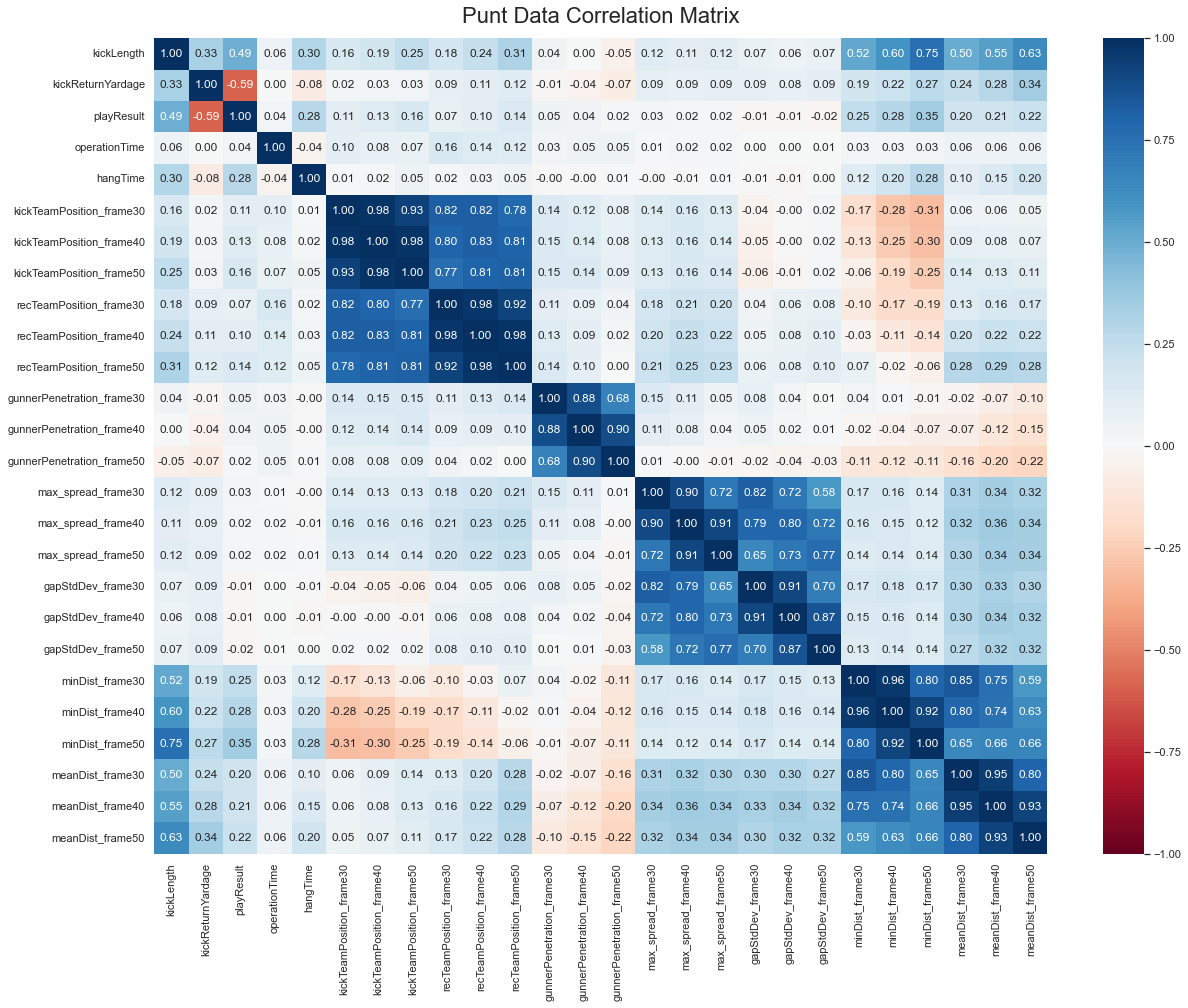

In [ ]:
corr = punt_data_co[new_order[9:]].corr()
plt.figure(figsize=[20,15])
ax = plt.axes()
plt.rcParams.update({'font.size': 12})
ax.set_title('Punt Data Correlation Matrix', fontsize=22, pad=15)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu', annot=True, fmt='.2f', vmin=-1.0)
plt.show();

## Classification Model

In [ ]:
def sequential_backward(model_data, target, classifier):
    test_columns = list(model_data.columns)
    test_columns.remove(target)
    feature_combos = pd.DataFrame()
    backward_order = []
    while test_columns:
        cols = test_columns + [target]
        data = model_data[cols]
        X = data.drop(columns=target)
        Y = data[target] 
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        score = accuracy_score(y_test, y_pred, normalize = True)
        test_instance = {'combo' : ', '.join(test_columns), 'score' : score, 'length' : len(test_columns)}
        feature_combos = feature_combos.append(test_instance, ignore_index=True)
        feature_importance = pd.Series(classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)
        remove = feature_importance.index[-1]
        test_columns.remove(remove)
        backward_order.extend([remove])
    sorted_combos = feature_combos.sort_values('score', ascending=False).reset_index()
    return backward_order, sorted_combos

In [ ]:
def sequential_forward(model_data, target, classifier):
    test_columns = list(model_data.columns)
    test_columns.remove(target)  
    feature_combos = pd.DataFrame()
    forward_order = []
    i = 1
    while test_columns:
        for col in test_columns:
            cols = [target] + forward_order + [col]
            data = model_data[cols].copy()
            X = data.drop(columns=target)
            Y = data[target]
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)
            classifier.fit(x_train, y_train)
            y_pred = classifier.predict(x_test)
            score = accuracy_score(y_test, y_pred, normalize = True)
            test_instance = {'combo' : ', '.join(cols), 'score' : score, 'length' : i}
            feature_combos = feature_combos.append(test_instance, ignore_index=True)
        remove = feature_combos[feature_combos['length']==i].sort_values('score', ascending=False).reset_index().loc[0,'combo'].split(', ')[-1]
        test_columns.remove(remove)
        forward_order.extend([remove])
        i += 1
    sorted_combos = feature_combos.sort_values('score', ascending=False).reset_index()
    sorted_combos = sorted_combos.drop_duplicates(subset='length', keep='first')
    return forward_order, sorted_combos

In [ ]:
def balance_target(df, target):
    limit = df[target].value_counts()[-1]
    balanced_df = pd.DataFrame()
    for value in df[target].value_counts().index:
        subset = df[df[target] == value]
        subset = subset.sample(limit, random_state=13)
        balanced_df = pd.concat([balanced_df, subset])
    return balanced_df

In [ ]:
punt_classification = punt_data_co.copy()
punt_classification['penaltyCodes'] = punt_classification['penaltyCodes'].astype(str)
punt_classification = punt_classification[(punt_classification['specialTeamsResult'] != 'Muffed') & (punt_classification['penaltyCodes'] == 'nan')]
conditions = [punt_classification['kickReturnYardage'].le(5), punt_classification['kickReturnYardage'].gt(5) & punt_classification['kickReturnYardage'].le(15), punt_classification['kickReturnYardage'].gt(15)]
choices = ['<5', '5-15', '15+']
punt_classification['kickReturnYardageBucket'] = np.select(conditions, choices)
punt_classification['kickDirectionActual'] = np.where(punt_classification['kickDirectionActual']=='C', 0, 1)
punt_classification['kickReturnYardageBucket'] = np.where(punt_classification['specialTeamsResult']=='Fair Catch','Fair Catch', punt_classification['kickReturnYardageBucket'])
punt_classification_balance = balance_target(punt_classification, 'kickReturnYardageBucket')
x_cols = ['kickLength', 'operationTime', 'hangTime', 'kickDirectionActual', 'kickTeamPosition_frame30', 'recTeamPosition_frame30', 'kickTeamPosition_frame40', 'recTeamPosition_frame40', 'kickTeamPosition_frame50', 'recTeamPosition_frame50', 'gunnerPenetration_frame30', 'gunnerPenetration_frame40', 'gunnerPenetration_frame50', 'max_spread_frame30', 'max_spread_frame40', 'max_spread_frame50', 'gapStdDev_frame30', 'gapStdDev_frame40', 'gapStdDev_frame50', 'minDist_frame30', 'minDist_frame40', 'minDist_frame50', 'meanDist_frame40', 'meanDist_frame40', 'meanDist_frame50']
y_cols = ['kickReturnYardageBucket']
X = punt_classification_balance[x_cols]
Y = punt_classification_balance[y_cols]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)

In [ ]:
rf_classifier = RandomForestClassifier(random_state=13)
rf_classifier.fit(x_train, y_train.values.ravel())
y_pred_train = rf_classifier.predict(x_train)
y_pred_test = rf_classifier.predict(x_test)
rf_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
rf_test_score = accuracy_score(y_test, y_pred_test, normalize = True)
print('Training Score:   ' + str(rf_train_score))
print('Test Score: ' + str(rf_test_score))

Training Score:   1.0
Test Score: 0.41452991452991456


In [ ]:
pd.Series(rf_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)

meanDist_frame50             0.088512
hangTime                     0.067845
meanDist_frame40             0.061552
kickLength                   0.057212
meanDist_frame40             0.046163
minDist_frame50              0.042753
max_spread_frame50           0.038479
gunnerPenetration_frame30    0.037580
max_spread_frame40           0.037153
minDist_frame30              0.036902
max_spread_frame30           0.036893
recTeamPosition_frame50      0.036025
gunnerPenetration_frame40    0.035799
gapStdDev_frame30            0.035769
recTeamPosition_frame40      0.035332
gunnerPenetration_frame50    0.035112
operationTime                0.034088
recTeamPosition_frame30      0.033891
gapStdDev_frame50            0.033891
gapStdDev_frame40            0.033416
kickTeamPosition_frame40     0.032592
kickTeamPosition_frame50     0.032569
kickTeamPosition_frame30     0.032451
minDist_frame40              0.032323
kickDirectionActual          0.005700
dtype: float64

In [ ]:
punt_classification_balance = punt_classification_balance[x_cols + y_cols]

In [ ]:
backward_order, sorted_combos_backward = sequential_backward(punt_classification_balance, 'kickReturnYardageBucket', rf_classifier)
forward_order, sorted_combos_forward = sequential_forward(punt_classification_balance, 'kickReturnYardageBucket', rf_classifier)

In [ ]:
backward_order[::-1]

['meanDist_frame50',
 'minDist_frame50',
 'hangTime',
 'recTeamPosition_frame50',
 'max_spread_frame40',
 'kickLength',
 'kickTeamPosition_frame30',
 'meanDist_frame40',
 'gunnerPenetration_frame50',
 'max_spread_frame50',
 'gapStdDev_frame50',
 'kickTeamPosition_frame40',
 'minDist_frame30',
 'gapStdDev_frame30',
 'recTeamPosition_frame40',
 'gunnerPenetration_frame30',
 'meanDist_frame40',
 'gunnerPenetration_frame40',
 'max_spread_frame30',
 'kickTeamPosition_frame50',
 'gapStdDev_frame40',
 'recTeamPosition_frame30',
 'minDist_frame40',
 'operationTime',
 'kickDirectionActual']

In [ ]:
sorted_combos_backward[0:5]

,index,combo,score,length
0,17,"kickLength, hangTime, kickTeamPosition_frame30...",0.444444,8.0
1,2,"kickLength, hangTime, kickTeamPosition_frame30...",0.435897,23.0
2,5,"kickLength, hangTime, kickTeamPosition_frame30...",0.435897,20.0
3,15,"kickLength, hangTime, kickTeamPosition_frame30...",0.427350,10.0
4,18,"kickLength, hangTime, kickTeamPosition_frame30...",0.423077,7.0


In [ ]:
# Using forward selection display feature order
forward_order

['kickLength',
 'gapStdDev_frame30',
 'hangTime',
 'recTeamPosition_frame40',
 'gapStdDev_frame50',
 'kickTeamPosition_frame40',
 'gunnerPenetration_frame30',
 'kickTeamPosition_frame30',
 'recTeamPosition_frame30',
 'operationTime',
 'kickDirectionActual',
 'meanDist_frame50',
 'recTeamPosition_frame50',
 'max_spread_frame40',
 'kickTeamPosition_frame50',
 'meanDist_frame40',
 'minDist_frame50',
 'gunnerPenetration_frame40',
 'max_spread_frame30',
 'minDist_frame40',
 'max_spread_frame50',
 'gapStdDev_frame40',
 'minDist_frame30',
 'meanDist_frame40',
 'gunnerPenetration_frame50']

In [ ]:
sorted_combos_forward[0:5]

,index,combo,score,length
0,156,"kickReturnYardageBucket, kickLength, gapStdDev...",0.495726,8.0
2,235,"kickReturnYardageBucket, kickLength, gapStdDev...",0.487179,13.0
3,141,"kickReturnYardageBucket, kickLength, gapStdDev...",0.487179,7.0
6,119,"kickReturnYardageBucket, kickLength, gapStdDev...",0.478632,6.0
7,189,"kickReturnYardageBucket, kickLength, gapStdDev...",0.478632,10.0


In [ ]:
x_cols = sorted_combos_forward.combo[0].split(', ')[1:]
X = punt_classification_balance[x_cols]
Y = punt_classification_balance[y_cols]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)

In [ ]:
rf_classifier = RandomForestClassifier(random_state=13)
rf_classifier.fit(x_train, y_train.values.ravel())
y_pred_train = rf_classifier.predict(x_train)
y_pred_test = rf_classifier.predict(x_test)
rf_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
rf_test_score = accuracy_score(y_test, y_pred_test, normalize = True)
print('Training Score:   ' + str(rf_train_score))
print('Test Score: ' + str(rf_test_score))

Training Score:   1.0
Test Score: 0.49572649572649574


In [ ]:
pd.Series(rf_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)

kickLength                   0.157650
hangTime                     0.135682
recTeamPosition_frame40      0.124841
gapStdDev_frame30            0.124125
gapStdDev_frame50            0.123494
gunnerPenetration_frame30    0.117753
kickTeamPosition_frame40     0.111025
kickTeamPosition_frame30     0.105430
dtype: float64

### Hyperparameter Tuning on Top Classifier Model

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_classifier = RandomForestClassifier(random_state=13)
rf_random = RandomizedSearchCV(estimator=rf_classifier,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               verbose=2,
                               random_state=13,
                               n_jobs = -1)
rf_random.fit(x_train, y_train.values.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=13),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=13, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [ ]:
rf_random_score = rf_random.best_estimator_.score(x_test, y_test)
print('Random Forest Classification Accuracy:  ' + str(format(rf_random_score, '.4f')))

Random Forest Classification Accuracy:  0.4744


In [ ]:
best_rf_classifier = rf_random.best_estimator_
pd.Series(best_rf_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)

kickLength                   0.175260
hangTime                     0.142669
recTeamPosition_frame40      0.123204
gapStdDev_frame50            0.119356
gapStdDev_frame30            0.119008
gunnerPenetration_frame30    0.111638
kickTeamPosition_frame30     0.104550
kickTeamPosition_frame40     0.104317
dtype: float64

## Coverage Throughout the Return

In [ ]:
punt_received = punt_t[(punt_t['event']=='punt_received')][['gameId', 'playId']]
punt_received = punt_received.merge(plays[['gameId', 'playId', 'specialTeamsResult', 'possessionTeam', 'penaltyJerseyNumbers']], on=['gameId', 'playId'])
punt_received['penaltyTeam'] = np.where(punt_received.apply(lambda x: str(x['possessionTeam']) in str(x['penaltyJerseyNumbers']), axis=1), np.where(punt_received.apply(lambda x: ';' in str(x["penaltyJerseyNumbers"]), axis=1), 'Both', 'Kicking'), np.where(punt_received['penaltyJerseyNumbers'].astype(str)=='nan', 'None', 'Receiving'))
punt_returned = punt_received[(~(punt_received['specialTeamsResult'].isin(['Muffed', 'Fair Catch']))) & (~(punt_received['penaltyTeam'].isin(['Both', 'Receiving'])))]
starting_cols = ['gameId', 'playId', 'specialTeamsResult', 'possessionTeam', 'penaltyJerseyNumbers', 'penaltyTeam'] 
merge_cols = ['gameId', 'playId', 'frameVsSnap']
punt_returned = punt_returned.merge(punt_t[punt_t['event']=='punt_received'][merge_cols], on=['gameId', 'playId'], how='left')
punt_returned = punt_returned.merge(punt_t[punt_t['event']=='out_of_bounds'][merge_cols], on=['gameId', 'playId'], how='left', suffixes=('_rec', '_oob'))
punt_returned = punt_returned.merge(punt_t[punt_t['event']=='tackle'][merge_cols], on=['gameId', 'playId'], how='left', suffixes=('_oob', '_tackle'))
punt_returned = punt_returned.merge(punt_t[punt_t['event']=='touchdown'][merge_cols], on=['gameId', 'playId'], how='left', suffixes=('_tackle', '_td'))
punt_returned = punt_returned.merge(punt_t[punt_t['event']=='fumble'][merge_cols], on=['gameId', 'playId'], how='left', suffixes=('_td', '_fumble'))
punt_returned.columns = starting_cols + ['returnStart', 'outOfBounds', 'tackle', 'touchdown', 'fumble']
punt_returned = punt_returned.drop_duplicates()
punt_returned['returnEnd'] = punt_returned[['outOfBounds','tackle', 'touchdown']].min(axis=1)
punt_returned.dropna(subset=['returnEnd'], inplace=True)
punt_returned = punt_returned[punt_returned['fumble'].astype(str)=='nan']

Defender Proximity

In [ ]:
football_position = punt_t[punt_t['rolePlayer']=='football'][['gameId', 'playId', 'frameVsSnap', 'x', 'y']]
football_position.columns = ['gameId', 'playId', 'frameVsSnap', 'x_football', 'y_football']
punt_t = punt_t.merge(football_position, on=['gameId', 'playId', 'frameVsSnap'])
punt_t['dist_to_football'] = np.sqrt((punt_t['x_football'] - punt_t['x'])**2 + (punt_t['y_football'] - punt_t['y'])**2)
dist_to_football = punt_t[(punt_t['kickingTeam'])].groupby(['gameId', 'playId', 'frameVsSnap'])['dist_to_football'].agg({np.min,np.mean}).reset_index()
dist_to_football.columns = ['gameId', 'playId', 'frameVsSnap', 'minDist_football', 'meanDist_football']
punt_tracking_during_return = punt_tracking.merge(punt_returned[['gameId', 'playId', 'returnStart', 'returnEnd']], on=['gameId', 'playId'])
punt_tracking_during_return.dropna(subset=['returnStart', 'returnEnd'], inplace=True)
punt_tracking_during_return = punt_tracking_during_return[(punt_tracking_during_return['frameVsSnap']>=punt_tracking_during_return['returnStart']) & (punt_tracking_during_return['frameVsSnap']<=punt_tracking_during_return['returnEnd'])]
punt_tracking_during_return['defender_within_two_yds'] = np.where((punt_tracking_during_return['dist_to_football'] <= 2.0) & (punt_tracking_during_return['kickingTeam']) & (punt_tracking_during_return['rolePlayer']!='football'), 1, 0)
close_defenders = punt_tracking_during_return.groupby(['gameId', 'playId'])['defender_within_two_yds'].sum().reset_index().sort_values('defender_within_two_yds', ascending=False)

Return Time

In [ ]:
punt_tracking_during_return['returnTime'] = punt_tracking_during_return['returnEnd'] - punt_tracking_during_return['returnStart']

Football Movement

In [ ]:
return_length = punt_tracking_during_return[['gameId', 'playId', 'frameVsSnap', 'x_football', 'y_football']].drop_duplicates()
return_length['x_change'] = return_length['x_football'].diff()
return_length['y_change'] = return_length['y_football'].diff()
return_length['football_movement'] = np.sqrt(return_length['x_change']**2 + return_length['y_change']**2)
mask = ((return_length['gameId']==return_length['gameId'].shift(1)) & (return_length['playId']==return_length['playId'].shift(1)))
return_length['football_movement'] = np.where(mask!=True, np.nan, return_length['football_movement'])
return_length = return_length.groupby(['gameId', 'playId'])['football_movement'].sum().reset_index()
return_difficulty = return_length.merge(close_defenders, on=['gameId', 'playId'], how='left')
return_difficulty = return_difficulty.merge(punt_tracking_during_return[['gameId', 'playId', 'returnTime']].drop_duplicates(), on=['gameId', 'playId'], how='left')

Broken Tackles

In [ ]:
pff['brokenTackles'] = pff['missedTackler'].str.count(';') + 1
return_difficulty = return_difficulty.merge(pff[['gameId', 'playId', 'brokenTackles']], on=['gameId', 'playId'], how='left')
return_difficulty['brokenTackles'].fillna(0, inplace=True)
return_difficulty_p = return_difficulty.copy()
for col in ['football_movement', 'defender_within_two_yds', 'returnTime', 'brokenTackles']:
    return_difficulty_p[col] = return_difficulty_p[col].rank(pct=True)
return_difficulty_p['difficulty'] = 0.25 * (return_difficulty_p['football_movement'] + return_difficulty_p['defender_within_two_yds'] + return_difficulty_p['returnTime'] + return_difficulty_p['brokenTackles'])
return_difficulty_p = return_difficulty_p.merge(games[['gameId', 'season', 'week', 'homeTeamAbbr', 'visitorTeamAbbr']], on=['gameId'])
return_difficulty_p = return_difficulty_p.merge(punt_t[['gameId', 'playId', 'possessionTeam', 'returnerId']].drop_duplicates(), on=['gameId', 'playId'])
return_difficulty_p = return_difficulty_p.merge(players[['nflId', 'displayName']], left_on=['returnerId'], right_on=['nflId'])
return_difficulty_p['returnTeam'] = np.where(return_difficulty_p['possessionTeam']==return_difficulty_p['homeTeamAbbr'], return_difficulty_p['visitorTeamAbbr'], return_difficulty_p['homeTeamAbbr'])
return_difficulty_p = return_difficulty_p.merge(punt_returned[['gameId', 'playId', 'touchdown']], on=['gameId', 'playId'])
return_difficulty_p['touchdown'] = np.where(return_difficulty_p['touchdown'] > 0, 'Yes', 'No')
presentation_order = ['season', 'week', 'homeTeamAbbr', 'visitorTeamAbbr', 'possessionTeam', 'returnTeam', 'displayName', 'touchdown', 'difficulty', 'defender_within_two_yds', 'football_movement', 'returnTime', 'brokenTackles']
new_names = ['Season', 'Week', 'Home', 'Away', 'Kick Team', 'Return Team', 'Returner', 'Touchdown', 'Difficulty', 'Defender Proximity','Total Movement', 'Return Time', 'Broken Tackles']
return_difficulty_presentation = return_difficulty_p[presentation_order]
return_difficulty_presentation.columns = new_names

### Punt Return Touchdowns - Degree of Difficulty

In [ ]:
cm = sns.color_palette('RdYlGn', as_cmap=True)
heatmap_cols = ['Difficulty', 'Defender Proximity', 'Total Movement', 'Return Time', 'Broken Tackles']
return_difficulty_presentation[return_difficulty_presentation['Touchdown']=='Yes'].sort_values('Difficulty', ascending=False).style.hide_index().background_gradient(cmap=cm, subset=heatmap_cols)

Season,Week,Home,Away,Kick Team,Return Team,Returner,Touchdown,Difficulty,Defender Proximity,Total Movement,Return Time,Broken Tackles
2018,1,DET,NYJ,DET,NYJ,Andre Roberts,Yes,0.928910,0.767246,0.998420,0.994734,0.955240
2020,17,BUF,MIA,MIA,BUF,Isaiah McKenzie,Yes,0.887309,0.597683,0.996840,0.999473,0.955240
2019,16,DEN,DET,DEN,DET,Jamal Agnew,Yes,0.863152,0.515271,0.989995,0.992101,0.955240
2019,16,IND,CAR,CAR,IND,Nyheim Hines,Yes,0.858083,0.492364,0.990521,0.994207,0.955240
2020,8,MIA,LA,LA,MIA,Jakeem Grant,Yes,0.848407,0.443128,0.998947,0.996314,0.955240
2018,5,CIN,MIA,CIN,MIA,Jakeem Grant,Yes,0.846432,0.443128,0.995261,0.992101,0.955240
2018,16,OAK,DEN,DEN,OAK,Dwayne Harris,Yes,0.828923,0.515271,1.000000,1.000000,0.800421
2020,13,LAC,NE,LAC,NE,Gunner Olszewski,Yes,0.816417,0.492364,0.987362,0.985519,0.800421
2019,16,IND,CAR,CAR,IND,Nyheim Hines,Yes,0.813454,0.467088,0.993154,0.993154,0.800421
2019,5,LAC,DEN,DEN,LAC,Desmond King,Yes,0.799368,0.413902,0.991048,0.992101,0.800421


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   2.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time=   2.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   2.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   2.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time=   1.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=True, max_depth=1